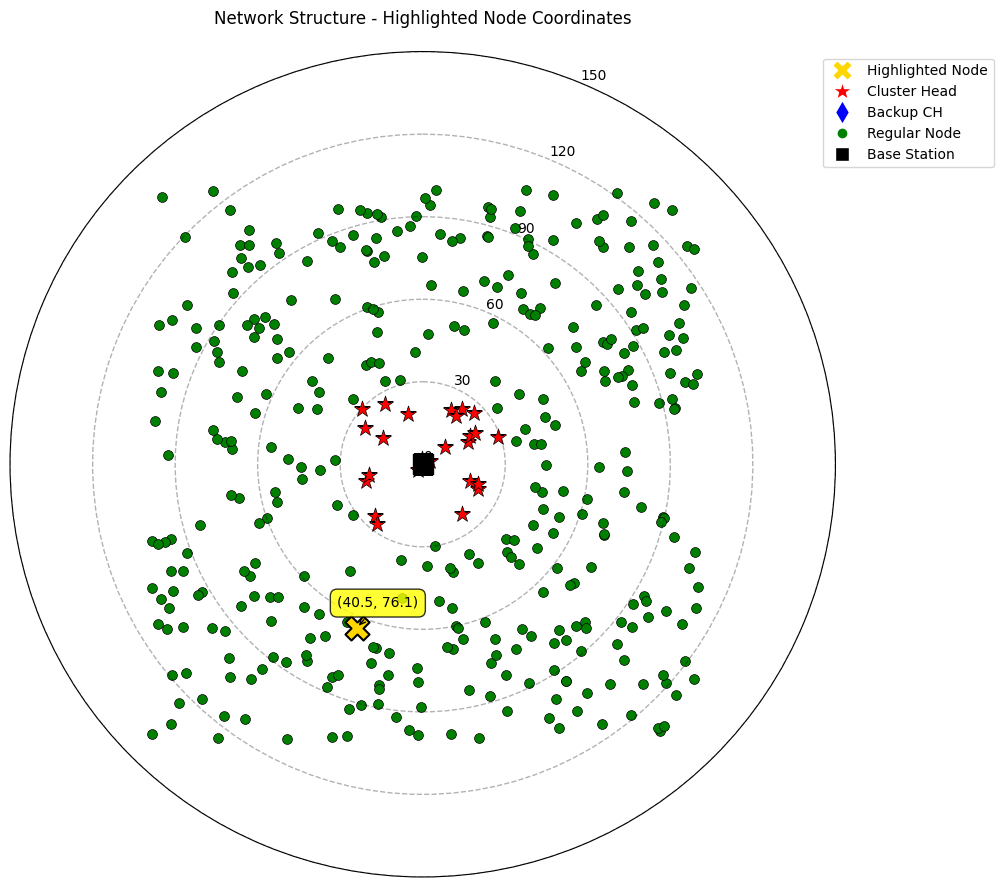

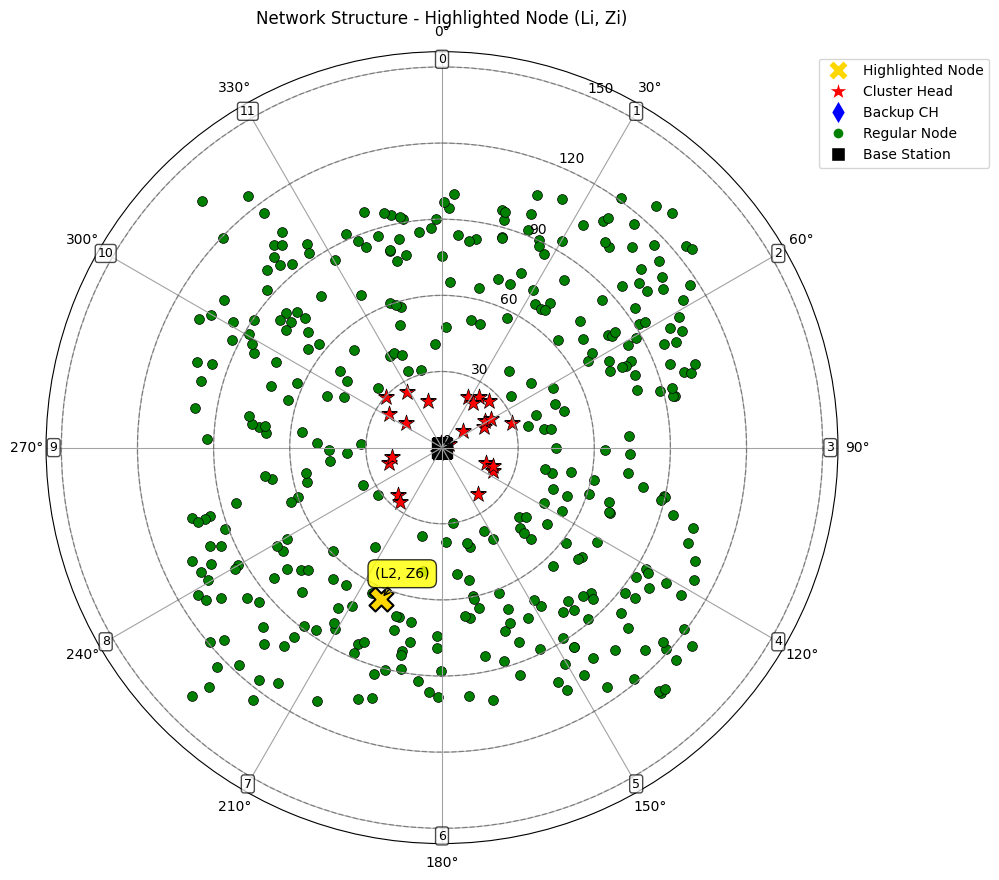

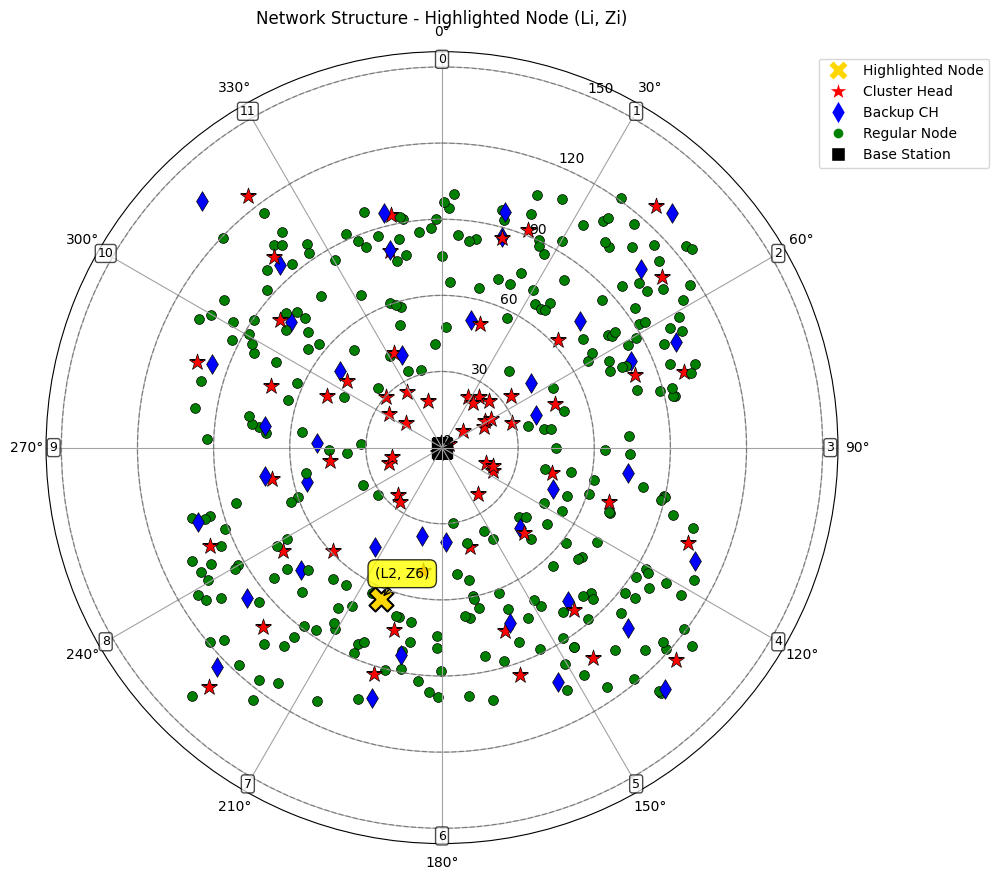

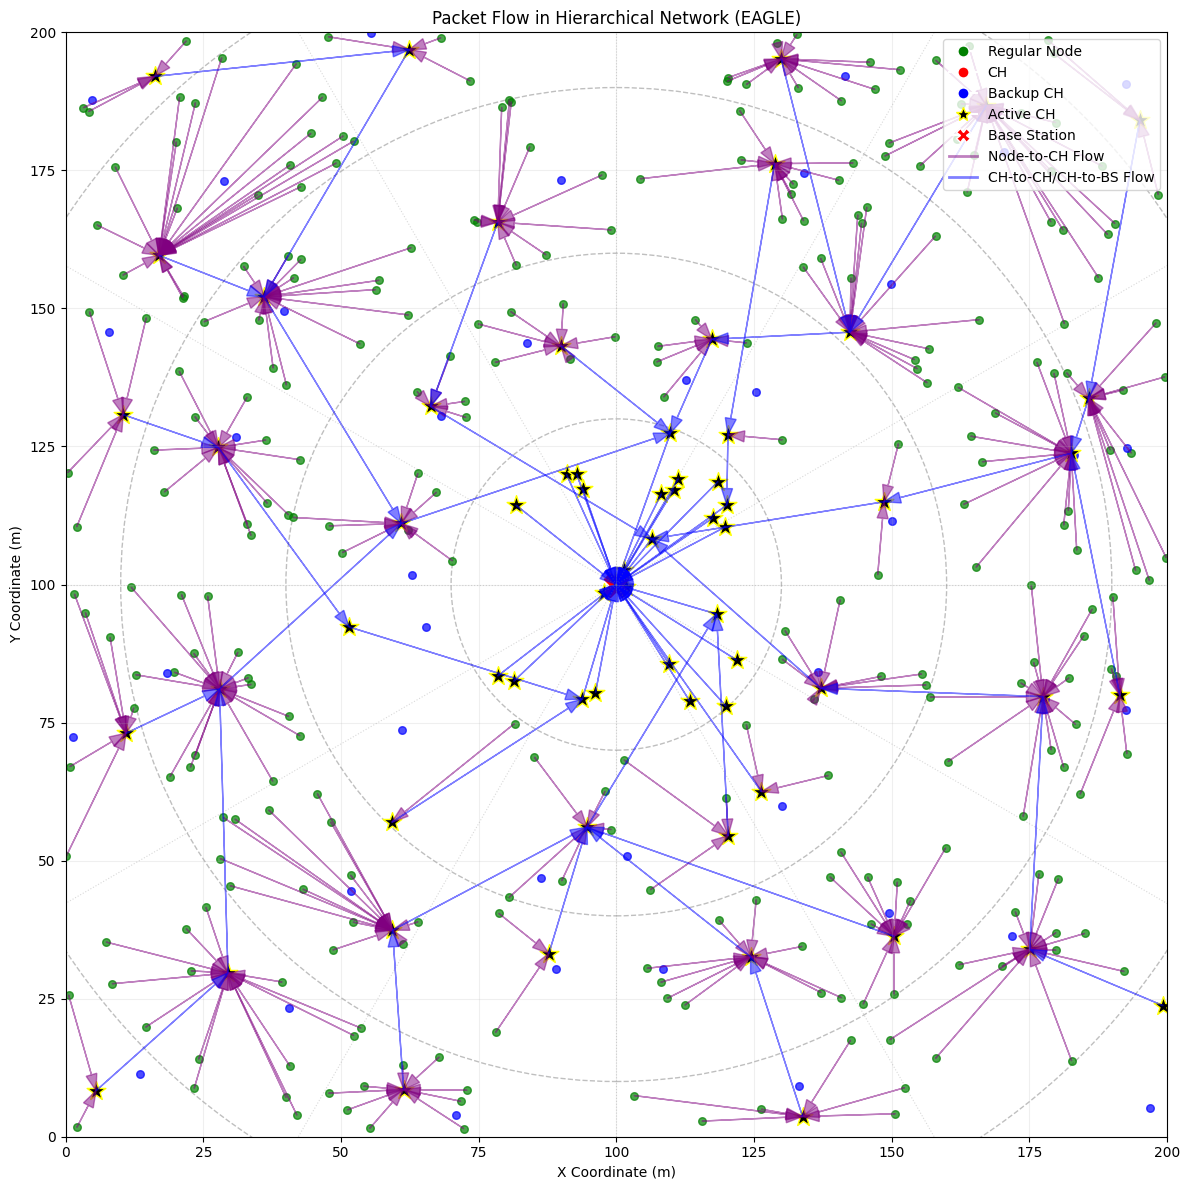

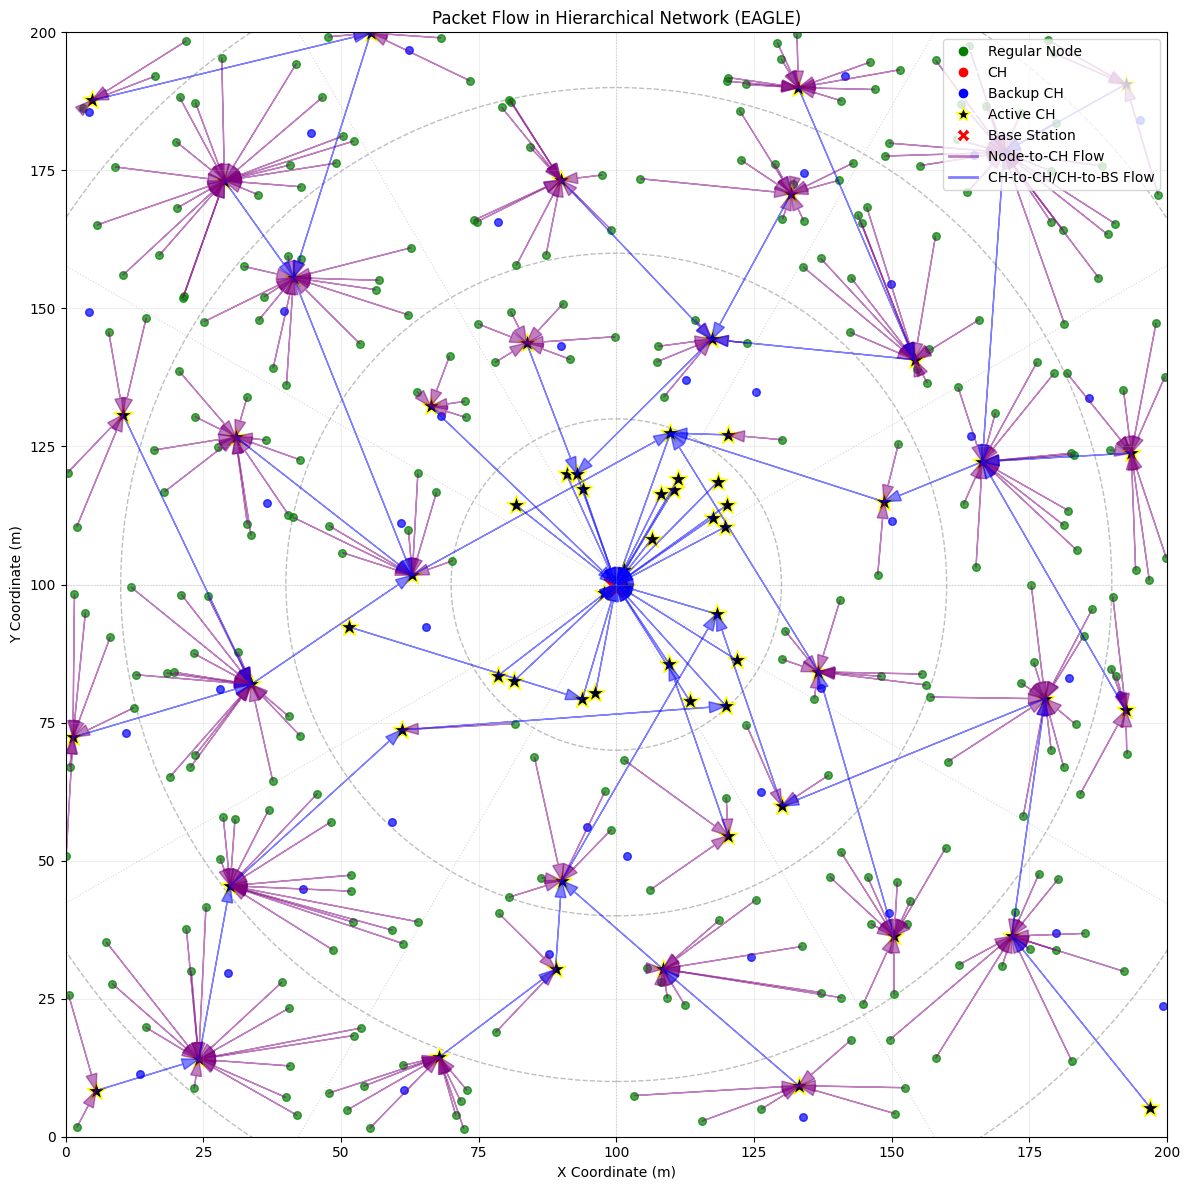

CH 383 in layer 3 zone 6 lacks sufficient energy
Round stats: 1 CH failures, 0 failed transmissions
CH 383 in layer 3 zone 6 lacks sufficient energy
Round stats: 1 CH failures, 0 failed transmissions
CH 383 in layer 3 zone 6 lacks sufficient energy
Round stats: 1 CH failures, 0 failed transmissions
CH 383 in layer 3 zone 6 lacks sufficient energy
Round stats: 1 CH failures, 0 failed transmissions
CH 392 in layer 3 zone 10 lacks sufficient energy
Round stats: 1 CH failures, 0 failed transmissions
CH 156 in layer 3 zone 1 lacks sufficient energy
Round stats: 1 CH failures, 0 failed transmissions
CH 134 in layer 3 zone 1 lacks sufficient energy
Round stats: 1 CH failures, 0 failed transmissions
CH 260 in layer 3 zone 10 lacks sufficient energy
Round stats: 1 CH failures, 0 failed transmissions
CH 286 in layer 3 zone 1 lacks sufficient energy
Round stats: 1 CH failures, 0 failed transmissions
CH 375 in layer 3 zone 1 lacks sufficient energy
Round stats: 1 CH failures, 0 failed transmission

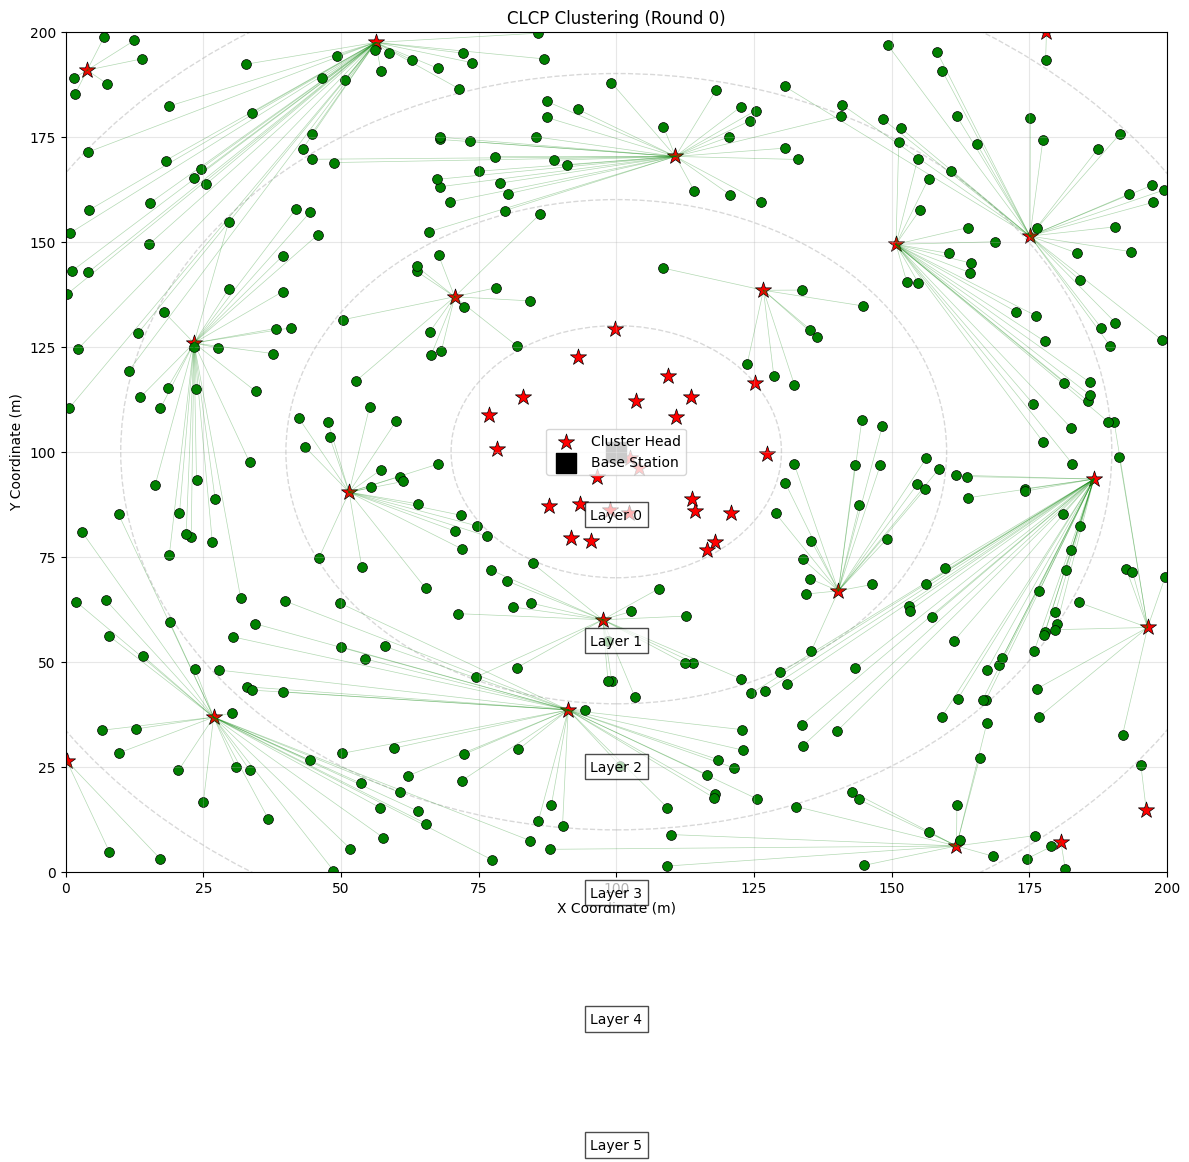

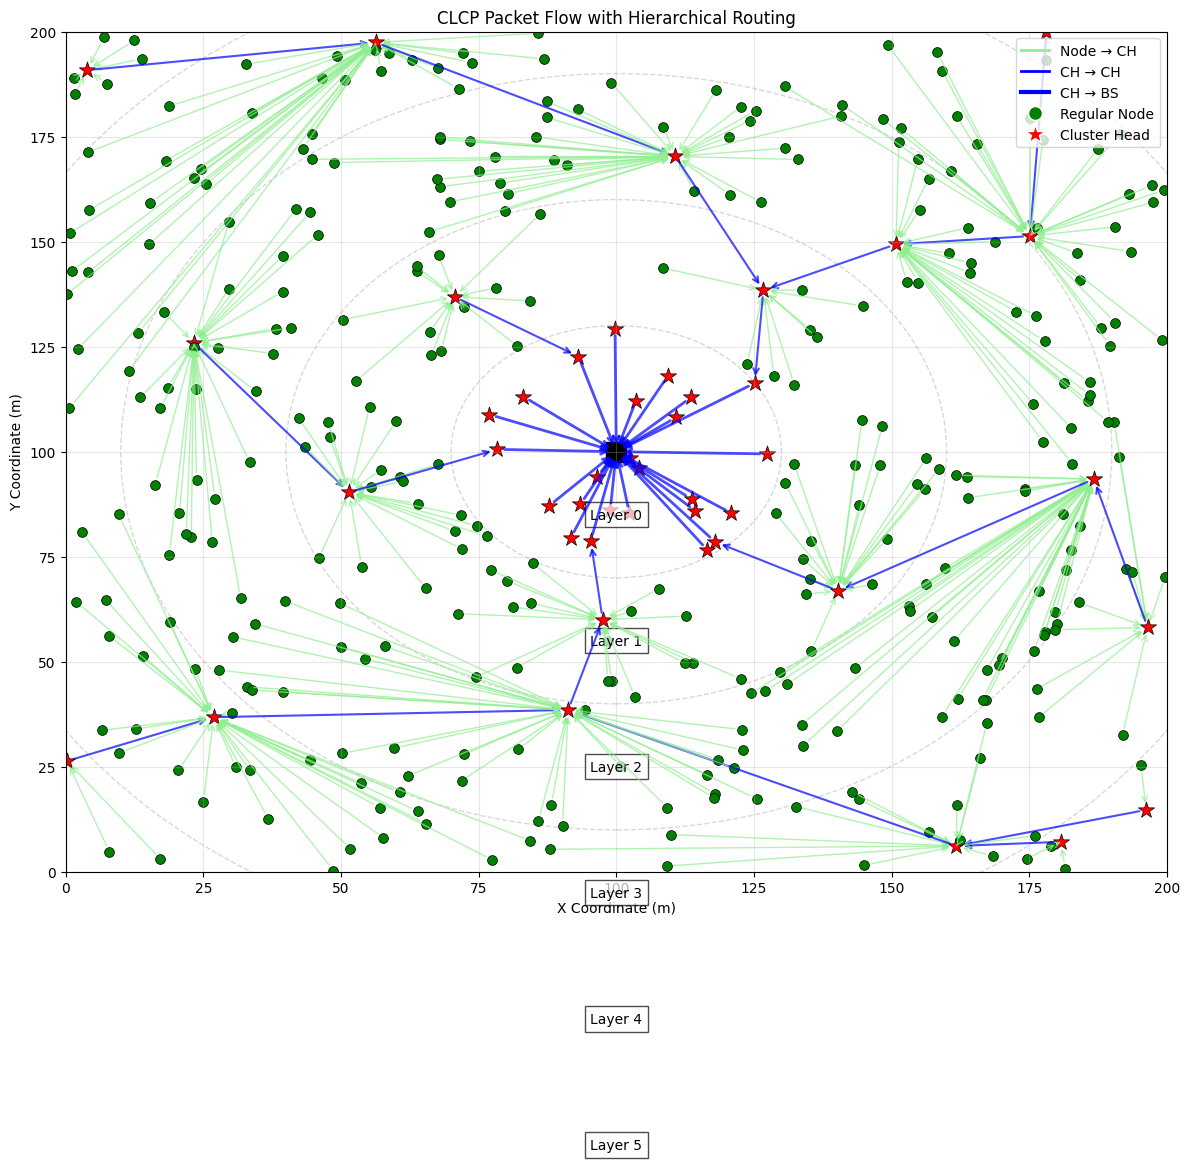

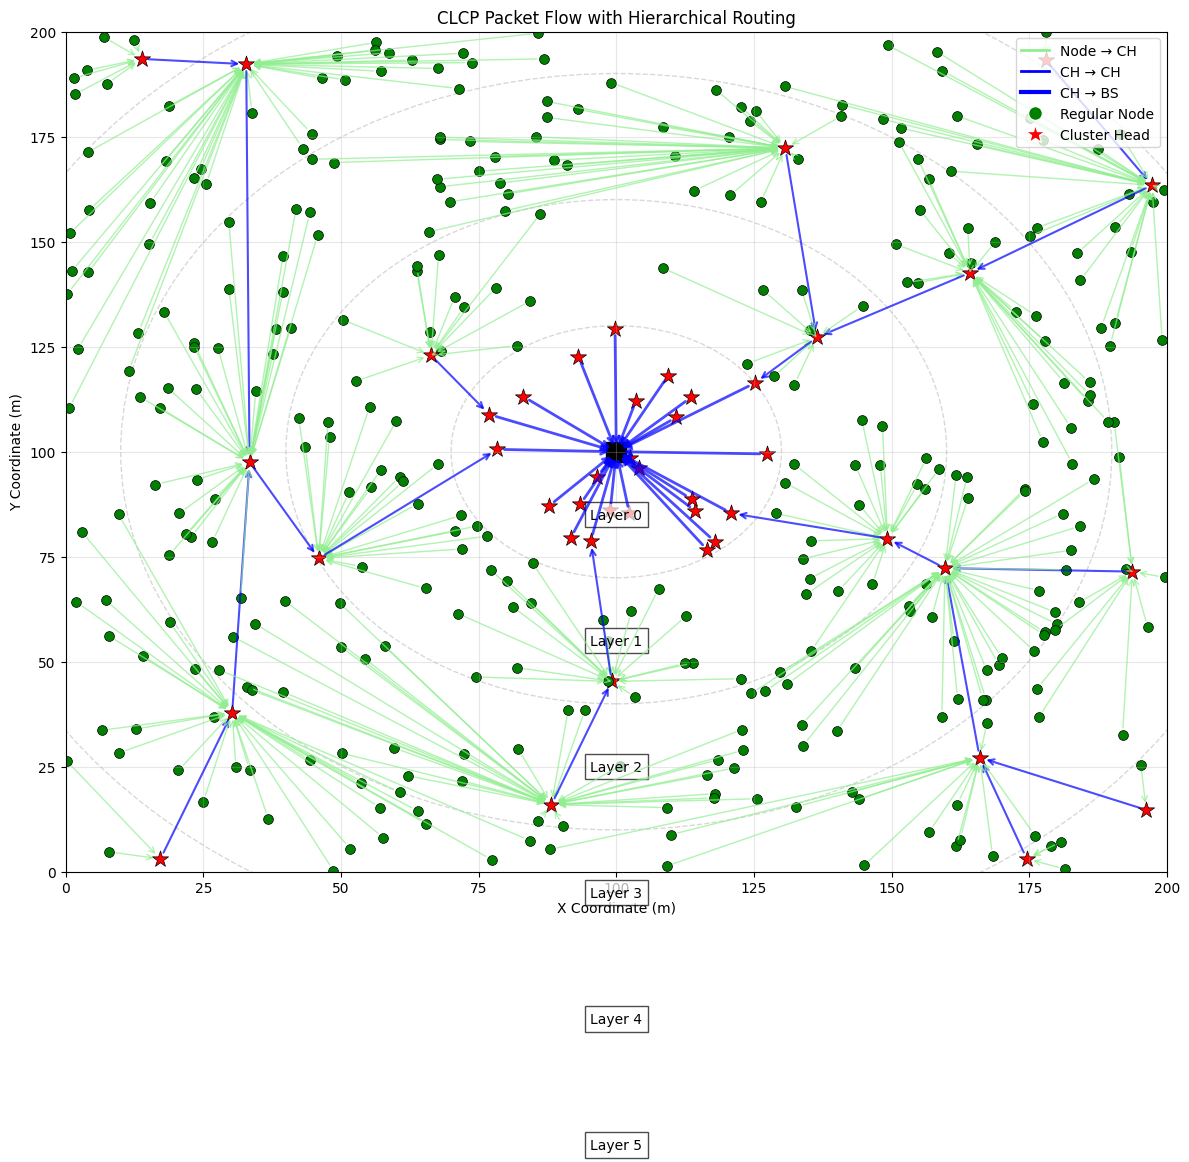

EAGLE Simulation completed in 1999 rounds
EAGLE FND: 552, HND: 1366
CLCP Simulation completed in 2000 rounds
CLCP FND: 119, HND: 688


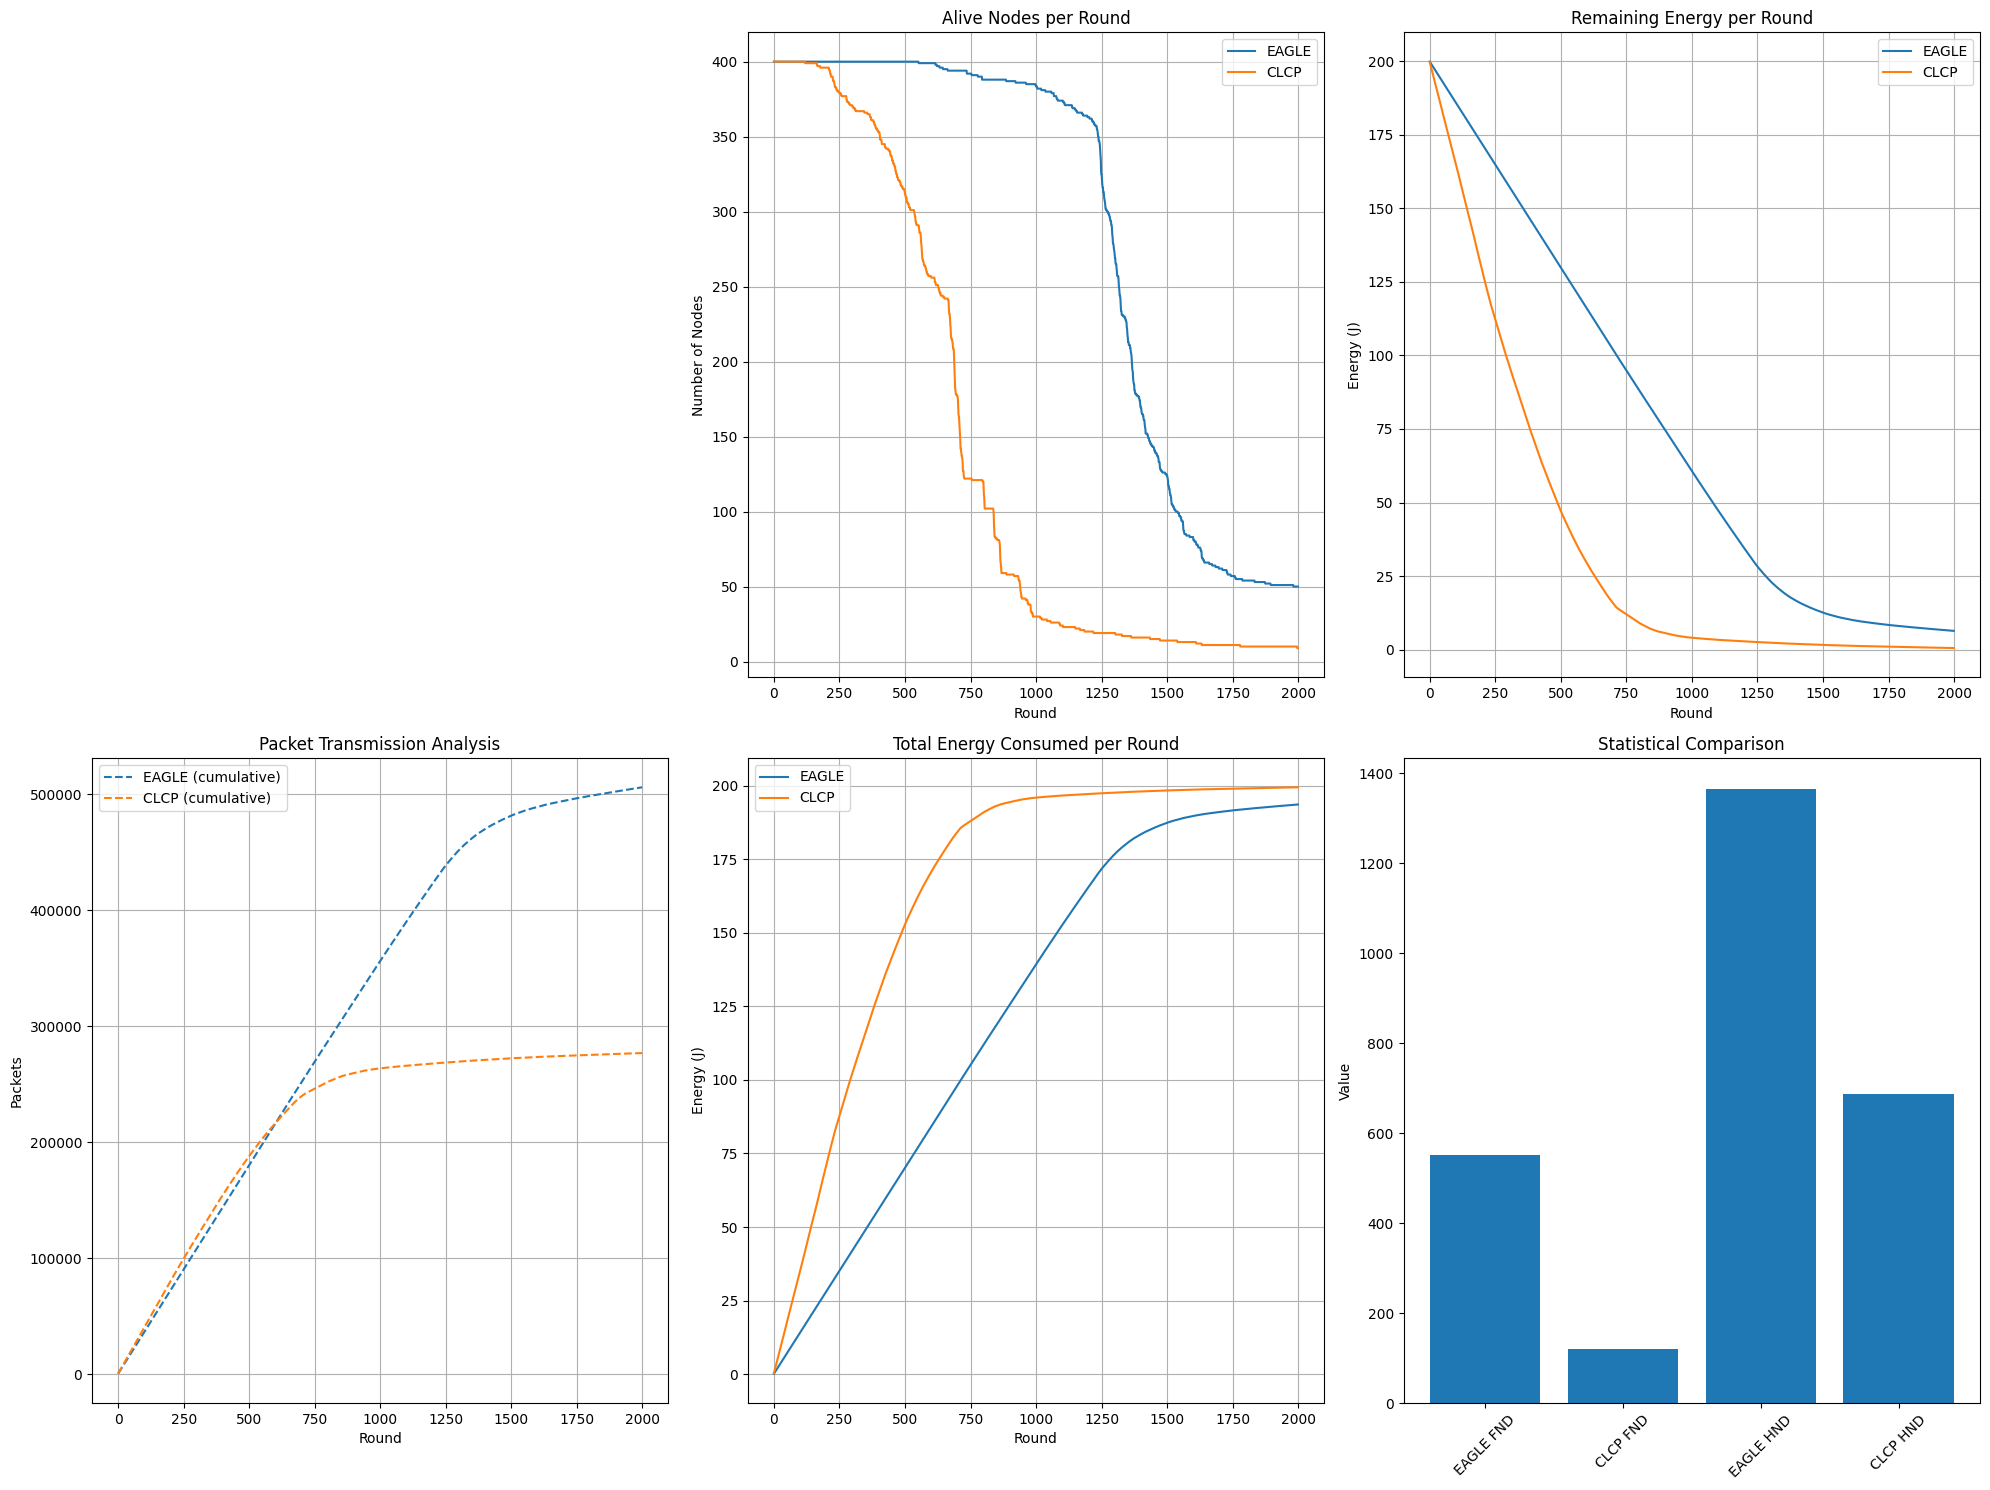

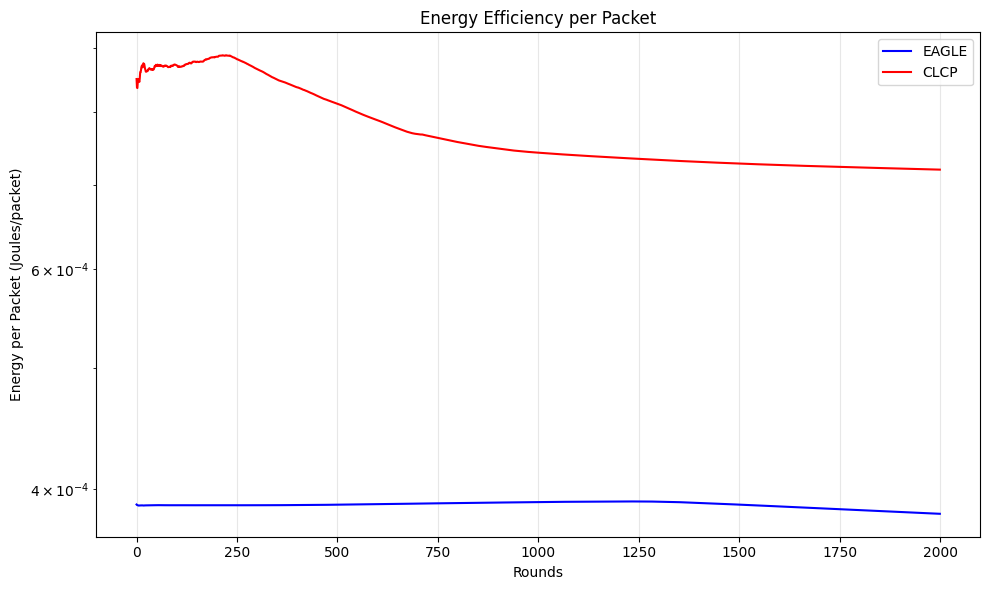

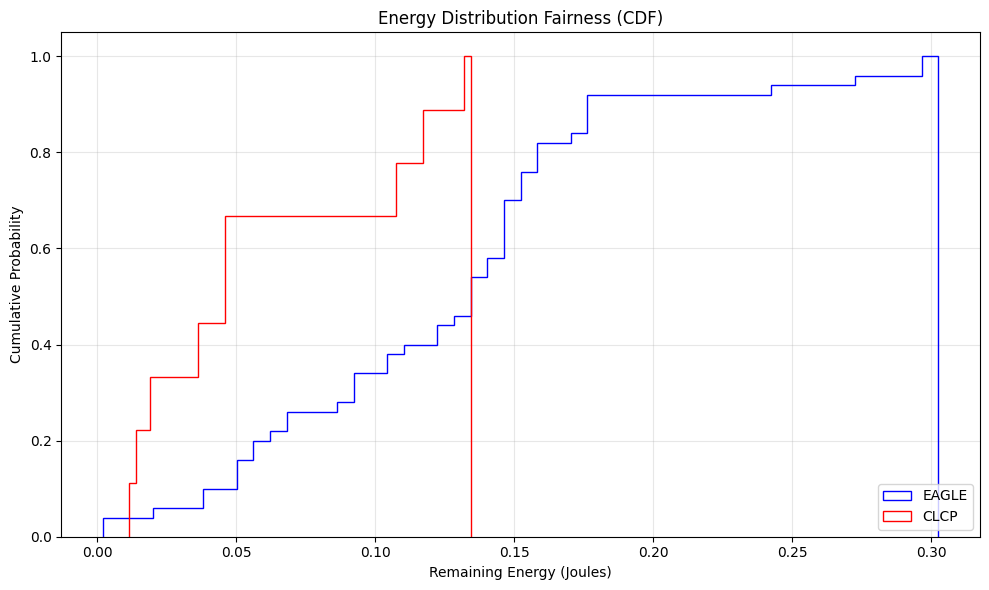

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import random
import math


# ================================================ CONSTANTS ================================================
NETWORK_SIZE = 200
NUM_NODES = 400
BS_POSITION = np.array([NETWORK_SIZE / 2, NETWORK_SIZE / 2])
TR_MIN = 30
INITIAL_ENERGY = 0.5
MIN_ENERGY_THRESHOLD = 0.001

E_AMP = 100e-12  # Amplifier energy
E_ELEC = 50e-9   #Energy to run transmitter electronics (50nJ/bit)
EPSILON_FS = 10e-12   #Free space amplifier energy (10pJ/bit/m²)
EPSILON_MP = 0.0013e-12   #Multi-path amplifier energy (0.0013pJ/bit/m⁴)
D0 = np.sqrt(EPSILON_FS / EPSILON_MP)   #Critical distance threshold
E_DA = 5e-9   #Data aggregation energy (5nJ/bit)
PACKET_SIZE = 4000
COMPRESSION_FACTOR = 0.8
MAX_ROUNDS = 2000
CH_ENERGY_THRESHOLD = 0.1 * INITIAL_ENERGY

# GA Parameters
GA_POPULATION_SIZE = 20
GA_GENERATIONS = 10
GA_MUTATION_RATE = 0.01

# Q-Learning Parameters
Q_LEARNING_ALPHA = 0.2  # Learning rate (α)
Q_LEARNING_GAMMA = 0.9  # Discount factor (γ)
Q_LEARNING_EPSILON = 0.3  # Exploration rate (ε)


# ================================================ CLASSES ================================================
class Node:
    def __init__(self, id):
        self.id = id
        self.energy = INITIAL_ENERGY
        self.position = np.array([random.uniform(0, NETWORK_SIZE), random.uniform(0, NETWORK_SIZE)])
        self.is_alive = True
        self.is_CH = False
        self.is_backup_CH = False
        self.level = None
        self.parent = None
        self.members = []

    def consume_energy(self, energy):
        self.energy = max(0, self.energy - energy)
        if self.energy < MIN_ENERGY_THRESHOLD:
            self.is_alive = False

class BaseStation:
    def __init__(self, position=BS_POSITION):
        self.position = position
        self.received_packets = 0
        self.is_alive = True  # Base station is always alive

class QLearning:
    def __init__(self, num_nodes):
        self.q_table = np.zeros((num_nodes, num_nodes))
        self.alpha = Q_LEARNING_ALPHA   # Learning rate (0.2)  "Controls how aggressively new information overrides old knowledge"
        self.gamma = Q_LEARNING_GAMMA   # Discount factor (0.9)  "Determines importance of future rewards"
        self.epsilon = Q_LEARNING_EPSILON   # Exploration rate (0.3)

    def choose_action(self, node_id, available_chs):
        if not available_chs:
            return None
        if random.random() < self.epsilon:
            return random.choice(available_chs)
        q_values = [self.q_table[node_id, ch.id] for ch in available_chs]
        return available_chs[np.argmax(q_values)]

    def update(self, node_id, old_ch_id, new_ch_id, reward):
        if old_ch_id is not None and new_ch_id is not None:
            old_q = self.q_table[node_id, old_ch_id]
            max_future_q = np.max(self.q_table[new_ch_id])
            new_q = old_q + self.alpha * (reward + self.gamma * max_future_q - old_q)   #Computes TD error: (reward + γ*max_future_q) - old_q
            self.q_table[node_id, old_ch_id] = new_q


# ================================================ CORE FUNCTIONS ================================================
def calculate_circular_layers_and_zones(nodes, base_station, tr_min):
    layers = {}
    zones = {}

    #Distance Calculations
    positions = np.array([node.position for node in nodes])
    distances = np.linalg.norm(positions - base_station.position, axis=1)   #Calculates Euclidean distances from base station to each node
    max_distance = np.max(distances)

    #Layer Determination
    L = int(np.ceil(max_distance / tr_min))
    for i, node in enumerate(nodes):
        layer = min(int(np.floor(distances[i] / tr_min)), L - 1)   #Computes total number of layers
        layers.setdefault(layer, []).append(node)

        #Zone Determination
        angle = math.atan2(node.position[1] - base_station.position[1], node.position[0] - base_station.position[0])   #Calculates angle (in radians) between node and base station using atan2
        zone = int((angle + math.pi) * 180 / math.pi) // 30   #Divides into 12 zones (360°/30° per zone) via integer division

        zones.setdefault(layer, {}).setdefault(zone, []).append(node)
        node.level = layer
    return layers, zones

#Calculates the energy required to transmit a packet over a given distance
def calculate_tx_energy(distance, packet_size):
    if distance < D0:
        return E_ELEC * packet_size + EPSILON_FS * packet_size * distance**2
    return E_ELEC * packet_size + EPSILON_MP * packet_size * distance**4

#Calculates energy required to receive a packet
def calculate_rx_energy(packet_size):
    return E_ELEC * packet_size

#Calculates energy for data aggregation at cluster heads
def calculate_aggregation_energy(packet_size):
    return E_DA * packet_size

def genetic_algorithm_ch_selection(zone_nodes):
    if not zone_nodes or all(not node.is_alive for node in zone_nodes):
        return None, None

    def fitness(individual):
        ch, backup_ch = individual
        if not ch.is_alive or not backup_ch.is_alive or ch == backup_ch:
            return 0
        mean_pos = np.mean([n.position for n in zone_nodes if n.is_alive], axis=0)
        dist_ch = np.linalg.norm(ch.position - mean_pos)
        dist_backup = np.linalg.norm(backup_ch.position - mean_pos)
        return (ch.energy + backup_ch.energy) / (dist_ch + dist_backup + 1e-6)   #1e-6 prevents division by zero

    #Population Initialization:
    alive_nodes = [n for n in zone_nodes if n.is_alive]
    if len(alive_nodes) < 2:
        return alive_nodes[0] if alive_nodes else None, None
    population = [random.sample(alive_nodes, 2) for _ in range(GA_POPULATION_SIZE)]   #20 random CH/backup pairs

    #Evolutionary Loop (10 Generations)
    for _ in range(GA_GENERATIONS):
        # Selection
        population = sorted(population, key=fitness, reverse=True)
        next_gen = population[:GA_POPULATION_SIZE // 2]   #Keeps top 50% performers

        # Reproduction (Crossover)
        while len(next_gen) < GA_POPULATION_SIZE:
            parent1, parent2 = random.sample(population[:GA_POPULATION_SIZE // 2], 2)   #Randomly selects two parents from top 50%
            child = parent1 if random.random() < 0.5 else parent2   #Child is either parent1 or parent2 (50% chance)

            # Mutation
            if random.random() < GA_MUTATION_RATE:   #1% chance (GA_MUTATION_RATE) to generate completely new pair
                child = random.sample(alive_nodes, 2)
            next_gen.append(child)
        population = next_gen

    best_individual = max(population, key=fitness)
    return best_individual[0], best_individual[1]



# ================================================ VISUALIZATION ================================================
def plot_hierarchical_network(nodes, layers, chs, base_station):
    # Select a random node that will be highlighted (same for both plots)
    highlight_node = random.choice([n for n in nodes if n.is_alive])
    highlight_pos = highlight_node.position

    plt.figure(figsize=(10, 10))  # Reduced figure size for better zoom
    ax = plt.subplot(111, polar=True)

    # Configure polar plot
    ax.grid(False)
    ax.set_axisbelow(False)
    ax.set_xticks(np.linspace(0, 2*np.pi, 12, endpoint=False))
    ax.set_xticklabels([])
    ax.set_yticks(np.arange(0, 5*TR_MIN+1, TR_MIN))  # Show ticks only at layer boundaries

    # Draw only 5 layer boundaries (0-4)
    for layer in range(5):
        boundary_radius = (layer + 1) * TR_MIN
        ax.plot(np.linspace(0, 2*np.pi, 100),
               [boundary_radius]*100,
               'k--', alpha=0.3, linewidth=1)

    # Plot nodes
    for node in nodes:
        if node.is_alive:
            r = np.linalg.norm(node.position - base_station.position)
            theta = math.atan2(node.position[1]-base_station.position[1],
                             node.position[0]-base_station.position[0])

            # Skip nodes beyond 5 layers
            if r > 5*TR_MIN:
                continue

            # Highlight our random node with coordinates
            if np.array_equal(node.position, highlight_pos):
                ax.scatter(theta, r, c='gold', s=300, marker='X',
                         edgecolors='black', linewidths=1.5)
                ax.annotate(f'({highlight_pos[0]:.1f}, {highlight_pos[1]:.1f})',
                           xy=(theta, r), xytext=(15, 15),
                           textcoords='offset points', ha='center',
                           bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.8),
                           arrowprops=dict(arrowstyle='->'))
                continue

            # Regular node styling
            if node.level == 0:
                color, marker, size = 'red', '*', 150
            elif node.is_CH:
                color, marker, size = 'red', '*', 150
            elif node.is_backup_CH:
                color, marker, size = 'blue', 'd', 100
            else:
                color, marker, size = 'green', 'o', 50

            ax.scatter(theta, r, c=color, s=size, marker=marker,
                      edgecolors='black', linewidths=0.5)

    # Base station and legend
    ax.scatter(0, 0, c='black', marker='s', s=200, label='Base Station')

    legend_elements = [
        plt.Line2D([0], [0], marker='X', color='w', label='Highlighted Node',
                  markerfacecolor='gold', markersize=15),
        plt.Line2D([0], [0], marker='*', color='w', label='Cluster Head',
                  markerfacecolor='red', markersize=15),
        plt.Line2D([0], [0], marker='d', color='w', label='Backup CH',
                  markerfacecolor='blue', markersize=12),
        plt.Line2D([0], [0], marker='o', color='w', label='Regular Node',
                  markerfacecolor='green', markersize=8),
        plt.Line2D([0], [0], marker='s', color='w', label='Base Station',
                  markerfacecolor='black', markersize=10)
    ]
    ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.2, 1))

    ax.set_title("Network Structure - Highlighted Node Coordinates", pad=20)
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.set_ylim(0, 5*TR_MIN)  # Zoom to show only 5 layers
    plt.tight_layout()
    plt.show()

    return highlight_node


def plot_hierarchical_network222(nodes, layers, chs, base_station, highlight_node):
    highlight_pos = highlight_node.position

    plt.figure(figsize=(10, 10))  # Reduced figure size
    ax = plt.subplot(111, polar=True)

    # Configure angular zones
    ax.set_xticks(np.linspace(0, 2*np.pi, 12, endpoint=False))
    #ax.set_xticklabels(range(12))  # Show zone numbers (0-11)
    ax.set_yticks(np.arange(0, 5*TR_MIN+1, TR_MIN))  # Only layer boundary ticks

    # Draw zone boundaries (lighter) and add zone labels
    for i, angle in enumerate(np.linspace(0, 2*np.pi, 12, endpoint=False)):
        ax.plot([angle, angle], [0, 5*TR_MIN], 'k-', alpha=0.1, linewidth=0.5)
        # Add zone number label at outer edge
        ax.text(angle, 5.1*TR_MIN, str(i), ha='center', va='center',
                fontsize=9, bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.2'))

    # Draw only 5 layer boundaries
    for layer in range(5):
        boundary_radius = (layer + 1) * TR_MIN
        ax.plot(np.linspace(0, 2*np.pi, 100), [boundary_radius]*100,
               'k--', alpha=0.3, linewidth=1)

    # Plot nodes
    for node in nodes:
        if node.is_alive:
            r = np.linalg.norm(node.position - base_station.position)

            # Skip nodes beyond 5 layers
            if r > 5*TR_MIN:
                continue

            theta = math.atan2(node.position[1]-base_station.position[1],
                             node.position[0]-base_station.position[0])

            # Highlight our random node with (Li, Zi) info
            if np.array_equal(node.position, highlight_pos):
                # Calculate layer and zone
                layer = int(r // TR_MIN)
                theta_corrected = (theta + 2*np.pi) % (2*np.pi)
                zone = int(theta_corrected // (np.pi/6)) % 12

                ax.scatter(theta, r, c='gold', s=300, marker='X',
                          edgecolors='black', linewidths=1.5)

                # Add (Li, Zi) label
                ax.annotate(f'(L{layer}, Z{zone})',
                           xy=(theta, r), xytext=(15, 15),
                           textcoords='offset points', ha='center',
                           bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.8),
                           arrowprops=dict(arrowstyle='->'))
                continue

            # Regular styling
            if node.level == 0:
                color, marker, size = 'red', '*', 150
            elif node.is_CH:
                color, marker, size = 'red', '*', 150
            elif node.is_backup_CH:
                color, marker, size = 'blue', 'd', 100
            else:
                color, marker, size = 'green', 'o', 50

            ax.scatter(theta, r, c=color, s=size, marker=marker,
                      edgecolors='black', linewidths=0.5)

    # Final touches
    ax.scatter(0, 0, c='black', marker='s', s=200, label='Base Station')
    legend_elements = [
        plt.Line2D([0], [0], marker='X', color='w', label='Highlighted Node',
                  markerfacecolor='gold', markersize=15),
        plt.Line2D([0], [0], marker='*', color='w', label='Cluster Head',
                  markerfacecolor='red', markersize=15),
        plt.Line2D([0], [0], marker='d', color='w', label='Backup CH',
                  markerfacecolor='blue', markersize=12),
        plt.Line2D([0], [0], marker='o', color='w', label='Regular Node',
                  markerfacecolor='green', markersize=8),
        plt.Line2D([0], [0], marker='s', color='w', label='Base Station',
                  markerfacecolor='black', markersize=10)
    ]
    ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.2, 1))

    ax.set_title("Network Structure - Highlighted Node (Li, Zi)", pad=20)
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.set_ylim(0, 5.2*TR_MIN)  # Slightly extended to show zone numbers
    plt.tight_layout()
    plt.show()







def plot_packet_flow(nodes, layers, chs, base_station, transmission_paths):
    """Visualize packet transmission paths with zone divisions"""
    plt.figure(figsize=(12, 12))
    ax = plt.gca()

    # Draw level boundaries
    for layer_idx in layers.keys():
        radius = (layer_idx + 1) * TR_MIN
        ax.add_artist(plt.Circle(
            (base_station.position[0], base_station.position[1]),
            radius=radius,
            color='gray',
            fill=False,
            linestyle='--',
            alpha=0.5
        ))

    # Add zone divisions (12 zones)
    center = base_station.position
    max_radius = NETWORK_SIZE
    for angle in np.linspace(0, 2*np.pi, 12, endpoint=False):
        # Calculate endpoint coordinates for zone line
        end_x = center[0] + max_radius * np.cos(angle)
        end_y = center[1] + max_radius * np.sin(angle)
        ax.plot([center[0], end_x], [center[1], end_y],
               color='gray',
               linestyle=':',
               alpha=0.3,
               linewidth=0.8)

    # Plot nodes
    for node in nodes:
        if node.is_alive:
            color = 'red' if node.is_CH else 'blue' if node.is_backup_CH else 'green'
            plt.scatter(
                node.position[0], node.position[1],
                color=color,
                s=30,
                alpha=0.7
            )

    # Plot CHs with special markers
    for layer_idx, layer_chs in chs.items():
        for zone_idx, ch in layer_chs.items():
            if ch.is_alive:
                plt.scatter(
                    ch.position[0], ch.position[1],
                    color='black',
                    marker='*',
                    s=200,
                    edgecolor='yellow',
                    linewidth=1
                )

    # Plot base station
    plt.scatter(
        base_station.position[0], base_station.position[1],
        color='red',
        marker='X',
        s=300,
        label='Base Station'
    )

    # Draw packet flow arrows with different colors
    for (start, end) in transmission_paths:
        # Determine if this is a node-to-CH transmission
        is_node_to_ch = False
        for node in nodes:
            # Check if start is a regular node (green) and end is a CH
            if (not node.is_CH and not node.is_backup_CH and
                node.position[0] == start[0] and node.position[1] == start[1]):
                # Check if end is a CH
                for layer in chs.values():
                    for ch in layer.values():
                        if ch.position[0] == end[0] and ch.position[1] == end[1]:
                            is_node_to_ch = True
                            break
                    if is_node_to_ch:
                        break
                if is_node_to_ch:
                    break

        arrow_color = 'purple' if is_node_to_ch else 'blue'

        plt.arrow(
            start[0], start[1],
            end[0]-start[0], end[1]-start[1],
            head_width=2,
            head_length=3,
            fc=arrow_color,
            ec=arrow_color,
            alpha=0.5,
            length_includes_head=True
        )

    # Create custom legend
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', label='Regular Node',
                  markerfacecolor='green', markersize=8),
        plt.Line2D([0], [0], marker='o', color='w', label='CH',
                  markerfacecolor='red', markersize=8),
        plt.Line2D([0], [0], marker='o', color='w', label='Backup CH',
                  markerfacecolor='blue', markersize=8),
        plt.Line2D([0], [0], marker='*', color='w', label='Active CH',
                  markerfacecolor='black', markersize=10, markeredgecolor='yellow'),
        plt.Line2D([0], [0], marker='X', color='w', label='Base Station',
                  markerfacecolor='red', markersize=10),
        plt.Line2D([0], [0], color='purple', alpha=0.5, label='Node-to-CH Flow',
                  linewidth=2),
        plt.Line2D([0], [0], color='blue', alpha=0.5, label='CH-to-CH/CH-to-BS Flow',
                  linewidth=2)
    ]

    plt.title('Packet Flow in Hierarchical Network (EAGLE)')
    plt.xlabel('X Coordinate (m)')
    plt.ylabel('Y Coordinate (m)')
    plt.legend(handles=legend_elements, loc='upper right')
    plt.grid(alpha=0.2)
    plt.xlim(0, NETWORK_SIZE)
    plt.ylim(0, NETWORK_SIZE)
    plt.tight_layout()
    plt.show()

def plot_network_advanced(eehrp_nodes, eehrp_chs, eehrp_metrics, eehrp_fnd, eehrp_hnd, kmeans_metrics, kmeans_fnd, kmeans_hnd, base_station):
    """Comprehensive comparison visualization"""
    plt.figure(figsize=(20, 15))

    # Subplot 2: Alive Nodes
    plt.subplot(2, 3, 2)
    plt.plot(eehrp_metrics['alive_nodes'], label="EAGLE")
    plt.plot(kmeans_metrics['alive_nodes'], label="CLCP")
    plt.title("Alive Nodes per Round")
    plt.xlabel("Round")
    plt.ylabel("Number of Nodes")
    plt.legend()
    plt.grid(True)

    # Subplot 3: Remaining Energy
    plt.subplot(2, 3, 3)
    plt.plot(eehrp_metrics['energy_consumption'], label="EAGLE")
    plt.plot(kmeans_metrics['energy_consumption'], label="CLCP")
    plt.title("Remaining Energy per Round")
    plt.xlabel("Round")
    plt.ylabel("Energy (J)")
    plt.legend()
    plt.grid(True)

    # Subplot 4: Packets to BS
    plt.subplot(2, 3, 4)
    # Plot both instantaneous and cumulative packets
    '''plt.plot(eehrp_metrics['packets_to_bs'],
             label="EAGLE (per round)", alpha=0.5)'''
    plt.plot(eehrp_metrics['cumulative_packets'],
             label="EAGLE (cumulative)", linestyle='--')

    '''plt.plot(kmeans_metrics['packets_to_bs'],
             label="CLCP (per round)", alpha=0.5)'''
    plt.plot(kmeans_metrics['cumulative_packets'],
             label="CLCP (cumulative)", linestyle='--')

    plt.title("Packet Transmission Analysis")
    plt.xlabel("Round")
    plt.ylabel("Packets")
    plt.legend()
    plt.grid(True)

    # Subplot 5: Total Energy Consumed
    plt.subplot(2, 3, 5)
    plt.plot(eehrp_metrics['total_energy_consumed'], label="EAGLE")
    plt.plot(kmeans_metrics['total_energy_consumed'], label="CLCP")
    plt.title("Total Energy Consumed per Round")
    plt.xlabel("Round")
    plt.ylabel("Energy (J)")
    plt.legend()
    plt.grid(True)

    # Subplot 6: Statistics
    plt.subplot(2, 3, 6)
    stats = {
        'EAGLE FND': eehrp_fnd if eehrp_fnd is not None else 0,
        'CLCP FND': kmeans_fnd if kmeans_fnd is not None else 0,
        'EAGLE HND': eehrp_hnd if eehrp_hnd is not None else 0,
        'CLCP HND': kmeans_hnd if kmeans_hnd is not None else 0,
        #'EAGLE Lifetime': len(eehrp_metrics['alive_nodes']),
        #'CLCP Lifetime': len(kmeans_metrics['alive_nodes']),
        #'EAGLE Total Packets': sum(eehrp_metrics['packets_to_bs']),
        #'CLCP Total Packets': sum(kmeans_metrics['packets_to_bs'])
    }
    plt.bar(stats.keys(), stats.values())
    plt.xticks(rotation=45)
    plt.title("Statistical Comparison")
    plt.ylabel("Value")

    plt.tight_layout()
    plt.show()


# ================================================ K-means VISUALIZATION ================================================
def plot_kmeans_clusters(nodes, chs, base_station, round_num):
    """Visualize K-means clusters in Cartesian coordinates with layers"""
    plt.figure(figsize=(12, 12))

    # Calculate layer boundaries
    max_distance = max(np.linalg.norm(node.position - base_station.position)
                     for node in nodes if node.is_alive) if nodes else 0
    max_layer = int(np.ceil(max_distance / TR_MIN))

    # Draw layer boundaries as circles
    for layer in range(max_layer + 1):
        circle = plt.Circle(
            (base_station.position[0], base_station.position[1]),
            radius=(layer + 1) * TR_MIN,
            color='gray',
            fill=False,
            linestyle='--',
            alpha=0.3
        )
        plt.gca().add_artist(circle)

        # Add layer label
        plt.text(
            base_station.position[0],
            base_station.position[1] - (layer + 0.5) * TR_MIN,
            f'Layer {layer}',
            ha='center',
            va='center',
            bbox=dict(facecolor='white', alpha=0.7)
        )

    # Plot nodes
    alive_nodes = [n for n in nodes if n.is_alive]
    for node in alive_nodes:
        if node.is_CH:
            color = 'red'
            marker = '*'
            size = 150
            label = 'Cluster Head'
        else:
            color = 'green'
            marker = 'o'
            size = 50
            label = 'Regular Node'

        plt.scatter(
            node.position[0], node.position[1],
            color=color,
            marker=marker,
            s=size,
            edgecolors='black',
            linewidths=0.5,
            label=label if node.id == 0 else ""
        )

    # Plot connections (node to CH)
    for node in alive_nodes:
        if node.parent and node.parent.is_alive:
            plt.plot(
                [node.position[0], node.parent.position[0]],
                [node.position[1], node.parent.position[1]],
                'g-',
                alpha=0.3,
                linewidth=0.5
            )

    # Plot base station
    plt.scatter(
        base_station.position[0], base_station.position[1],
        color='black',
        marker='s',
        s=200,
        label='Base Station'
    )

    plt.title(f"CLCP Clustering (Round {round_num})")
    plt.xlabel("X Coordinate (m)")
    plt.ylabel("Y Coordinate (m)")
    plt.grid(alpha=0.3)
    plt.xlim(0, NETWORK_SIZE)
    plt.ylim(0, NETWORK_SIZE)

    # Remove duplicate labels
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    plt.tight_layout()
    plt.show()

def plot_kmeans_packet_flow(nodes, chs, base_station, transmission_paths):
    """Visualize packet flow with clear arrow types in Cartesian coordinates"""
    plt.figure(figsize=(12, 12))

    # Calculate layer boundaries
    max_distance = max(np.linalg.norm(node.position - base_station.position)
                     for node in nodes if node.is_alive) if nodes else 0
    max_layer = int(np.ceil(max_distance / TR_MIN))

    # Draw layer boundaries
    for layer in range(max_layer + 1):
        circle = plt.Circle(
            (base_station.position[0], base_station.position[1]),
            radius=(layer + 1) * TR_MIN,
            color='gray',
            fill=False,
            linestyle='--',
            alpha=0.3
        )
        plt.gca().add_artist(circle)

        # Add layer label
        plt.text(
            base_station.position[0],
            base_station.position[1] - (layer + 0.5) * TR_MIN,
            f'Layer {layer}',
            ha='center',
            va='center',
            bbox=dict(facecolor='white', alpha=0.7)
        )

    # Plot nodes first (underneath arrows)
    alive_nodes = [n for n in nodes if n.is_alive]
    for node in alive_nodes:
        if node.is_CH:
            color = 'red'
            marker = '*'
            size = 150
        else:
            color = 'green'
            marker = 'o'
            size = 50

        plt.scatter(
            node.position[0], node.position[1],
            color=color,
            marker=marker,
            s=size,
            edgecolors='black',
            linewidths=0.5
        )

    # Plot packet flow with distinct arrow types
    for (start, end) in transmission_paths:
        # Determine arrow style
        start_is_CH = any(np.allclose(start, ch.position) for ch in chs if ch.is_alive)
        end_is_CH = any(np.allclose(end, ch.position) for ch in chs if ch.is_alive)
        end_is_BS = np.allclose(end, base_station.position)

        if end_is_BS:  # CH to BS
            arrow_color = 'blue'
            arrow_width = 2
            head_size = 8
            style = '->'
        elif start_is_CH and end_is_CH:  # CH to CH
            arrow_color = 'blue'
            arrow_width = 1.5
            head_size = 6
            style = '->'
        else:  # Node to CH
            arrow_color = 'lightgreen'
            arrow_width = 1
            head_size = 4
            style = '->'

        plt.annotate("",
            xy=end,
            xytext=start,
            arrowprops=dict(
                arrowstyle=style,
                color=arrow_color,
                lw=arrow_width,
                shrinkA=5,
                shrinkB=5,
                alpha=0.7
            )
        )

    # Plot base station
    plt.scatter(
        base_station.position[0], base_station.position[1],
        color='black',
        marker='s',
        s=200,
        label='Base Station'
    )

    # Create custom legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='lightgreen', lw=2, label='Node → CH'),
        Line2D([0], [0], color='blue', lw=2, label='CH → CH'),
        Line2D([0], [0], color='blue', lw=3, label='CH → BS'),
        Line2D([0], [0], marker='o', color='w', label='Regular Node',
              markerfacecolor='green', markersize=10),
        Line2D([0], [0], marker='*', color='w', label='Cluster Head',
              markerfacecolor='red', markersize=15)
    ]
    plt.legend(handles=legend_elements, loc='upper right')

    plt.title("CLCP Packet Flow with Hierarchical Routing")
    plt.xlabel("X Coordinate (m)")
    plt.ylabel("Y Coordinate (m)")
    plt.grid(alpha=0.3)
    plt.xlim(0, NETWORK_SIZE)
    plt.ylim(0, NETWORK_SIZE)
    plt.tight_layout()
    plt.show()


# ================================================ KNEW VISUALIZATION ================================================
#Energy per Packet Efficiency
def plot_energy_per_packet(eehrp_metrics, kmeans_metrics):
    plt.figure(figsize=(10,6))

    # Calculate energy per packet
    eehrp_eff = np.array(eehrp_metrics['total_energy_consumed']) / \
               (np.array(eehrp_metrics['cumulative_packets']) + 1e-10)
    kmeans_eff = np.array(kmeans_metrics['total_energy_consumed']) / \
                (np.array(kmeans_metrics['cumulative_packets']) + 1e-10)

    plt.plot(eehrp_eff, 'b-', label='EAGLE')
    plt.plot(kmeans_eff, 'r-', label='CLCP')

    plt.title('Energy Efficiency per Packet')
    plt.xlabel('Rounds')
    plt.ylabel('Energy per Packet (Joules/packet)')
    plt.yscale('log')  # Logarithmic scale often works better
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

#Energy Fairness Comparison
def plot_energy_fairness(nodes_eehrp, nodes_kmeans):
    plt.figure(figsize=(10,6))

    # Get remaining energies
    eehrp_energies = [n.energy for n in nodes_eehrp if n.is_alive]
    kmeans_energies = [n.energy for n in nodes_kmeans if n.is_alive]

    # Create CDF plots
    plt.hist(eehrp_energies, bins=50, density=True,
             histtype='step', cumulative=True,
             label='EAGLE', color='blue')
    plt.hist(kmeans_energies, bins=50, density=True,
             histtype='step', cumulative=True,
             label='CLCP', color='red')

    plt.title('Energy Distribution Fairness (CDF)')
    plt.xlabel('Remaining Energy (Joules)')
    plt.ylabel('Cumulative Probability')
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


# ================================================ EAGLE PROTOCOL ================================================
class EEHRPAdvanced:
    def __init__(self, nodes, base_station):
        self.nodes = nodes
        self.base_station = base_station
        self.q_learning = QLearning(len(nodes))
        self.layers, self.zones = calculate_circular_layers_and_zones(nodes, base_station, TR_MIN)
        self.chs = {}
        self.backup_chs = {}
        self.total_energy_consumed = 0
        self.transmission_paths = []
        self.cumulative_packets = 0
        self.dead_chs_this_round = 0
        self.failed_transmissions = 0

    def estimate_ch_energy_requirements(self, ch, num_members):
        """Calculate if CH has enough energy for its duties this round"""
        if not ch.is_alive:
            return False

        # Energy needed to receive from all members
        rx_energy = num_members * calculate_rx_energy(PACKET_SIZE)

        # Energy needed for data aggregation
        agg_energy = calculate_aggregation_energy(PACKET_SIZE * num_members)

        # Estimated transmission energy (average case)
        avg_distance = TR_MIN * 1.5  # Conservative estimate
        tx_energy = calculate_tx_energy(avg_distance, PACKET_SIZE * COMPRESSION_FACTOR)

        total_required = rx_energy + agg_energy + tx_energy

        # Keep 10% buffer
        return ch.energy > (total_required * 1.1)

    def check_ch_health(self, layer_idx, zone_idx, num_members=0):
        """Verify CH is alive AND capable of handling its duties"""
        ch = self.chs.get(layer_idx, {}).get(zone_idx)

        # Basic health check
        if not ch or not ch.is_alive:
            self.dead_chs_this_round += 1
            return self.activate_backup_ch(layer_idx, zone_idx, num_members)

        # Capability check
        if not self.estimate_ch_energy_requirements(ch, num_members):
            print(f"CH {ch.id} in layer {layer_idx} zone {zone_idx} lacks sufficient energy")
            self.dead_chs_this_round += 1
            return self.activate_backup_ch(layer_idx, zone_idx, num_members)

        return ch

    def activate_backup_ch(self, layer_idx, zone_idx, num_members):
        """Switch to backup CH with capability checking"""
        backup_ch = self.backup_chs.get(layer_idx, {}).get(zone_idx)

        # Check backup CH capability
        if backup_ch and backup_ch.is_alive and self.estimate_ch_energy_requirements(backup_ch, num_members):
            # Promote backup to primary CH
            backup_ch.is_CH = True
            backup_ch.is_backup_CH = False
            self.chs[layer_idx][zone_idx] = backup_ch

            # Select new backup
            zone_nodes = self.zones[layer_idx][zone_idx]
            _, new_backup = genetic_algorithm_ch_selection(
                [n for n in zone_nodes if n.is_alive and n != backup_ch]
            )
            if new_backup:
                new_backup.is_backup_CH = True
                self.backup_chs[layer_idx][zone_idx] = new_backup
            return backup_ch

        # Emergency CH selection if no suitable backup
        zone_nodes = self.zones[layer_idx][zone_idx]
        alive_nodes = [n for n in zone_nodes if n.is_alive]

        if alive_nodes:
            # Select node with highest energy that can handle the load
            for node in sorted(alive_nodes, key=lambda x: x.energy, reverse=True):
                if self.estimate_ch_energy_requirements(node, num_members):
                    node.is_CH = True
                    node.is_backup_CH = False
                    self.chs[layer_idx][zone_idx] = node
                    print(f"Emergency CH {node.id} promoted in layer {layer_idx}")
                    return node

        return None

    def find_parent_ch(self, current_layer, current_ch):
        """Find suitable parent CH with multi-layer fallback"""
        # Try immediate lower layer first
        for lower_layer in range(current_layer - 1, max(-1, current_layer - 3), -1):
            if lower_layer < 0:
                # Base station case
                if np.linalg.norm(current_ch.position - self.base_station.position) <= TR_MIN * 3:
                    return self.base_station
                continue

            available_chs = []
            for zone_ch in self.chs.get(lower_layer, {}).values():
                if (zone_ch.is_alive and
                    self.estimate_ch_energy_requirements(zone_ch, 1) and  # Can handle at least one more packet
                    np.linalg.norm(current_ch.position - zone_ch.position) <= TR_MIN * 2):
                    available_chs.append(zone_ch)

            if available_chs:
                # Use Q-learning to select from available CHs
                return self.q_learning.choose_action(current_ch.id, available_chs)

        return None

    def safe_transmit(self, sender, receiver, packet_size, is_aggregated=False):
        """Handle transmission with comprehensive failure recovery"""
        if not sender or not sender.is_alive:
            self.failed_transmissions += 1
            return False

        # Special handling for base station receiver
        if isinstance(receiver, BaseStation):
            # Base station is always alive and can receive
            pass
        elif not receiver or not receiver.is_alive or (
            hasattr(receiver, 'is_CH') and
            not self.estimate_ch_energy_requirements(receiver, 1)):

            if hasattr(receiver, 'level'):  # It's a CH node
                new_receiver = self.check_ch_health(receiver.level,
                                                   next((k for k,v in self.zones[receiver.level].items()
                                                        if receiver in v), 1))
                if new_receiver:
                    return self.safe_transmit(sender, new_receiver, packet_size, is_aggregated)
            self.failed_transmissions += 1
            return False

        try:
            distance = np.linalg.norm(sender.position - receiver.position)
            tx_energy = calculate_tx_energy(distance, packet_size)

            if sender.energy < tx_energy:
                self.failed_transmissions += 1
                return False

            sender.consume_energy(tx_energy)

            if not is_aggregated and not isinstance(receiver, BaseStation):
                # Only consume RX energy for non-aggregated packets and non-BS receivers
                rx_energy = calculate_rx_energy(packet_size)
                if hasattr(receiver, 'energy') and receiver.energy < rx_energy:
                    self.failed_transmissions += 1
                    return False
                receiver.consume_energy(rx_energy)

            return True
        except Exception as e:
            print(f"Transmission error between {sender.id} and {receiver.id}: {str(e)}")
            self.failed_transmissions += 1
            return False

    def communicate(self):
        self.transmission_paths = []
        self.dead_chs_this_round = 0
        self.failed_transmissions = 0
        round_packets = 0

        # Phase 1: Member to CH transmission with capability checking
        for layer_idx, layer_zones in self.zones.items():
            if layer_idx == 0:  # Skip layer 0 as all nodes are CHs
                continue

            for zone_idx, zone_nodes in layer_zones.items():
                num_members = sum(1 for n in zone_nodes if not n.is_CH and not n.is_backup_CH and n.is_alive)
                ch = self.check_ch_health(layer_idx, zone_idx, num_members)
                if not ch:
                    continue

                for node in zone_nodes:
                    if node.is_alive and not node.is_CH and not node.is_backup_CH:
                        if self.safe_transmit(node, ch, PACKET_SIZE):
                            ch.members.append(node)
                            round_packets += 1
                            self.transmission_paths.append((node.position, ch.position))

        # Phase 2: CH to upper layer transmission with multi-layer routing
        for layer_idx in sorted(self.chs.keys(), reverse=True):
            for zone_idx, ch in list(self.chs[layer_idx].items()):
                if not ch.is_alive:
                    continue

                # Re-check CH health after member transmissions
                ch = self.check_ch_health(layer_idx, zone_idx, len(ch.members))
                if not ch:
                    continue

                # Aggregation energy
                agg_energy = calculate_aggregation_energy(PACKET_SIZE * len(ch.members))
                if ch.energy < agg_energy:
                    ch.is_alive = False
                    continue
                ch.consume_energy(agg_energy)

                aggregated_size = PACKET_SIZE * COMPRESSION_FACTOR

                if layer_idx == 0:  # Direct to BS
                    if self.safe_transmit(ch, self.base_station, aggregated_size, True):
                        self.base_station.received_packets += 1
                        round_packets += 1
                        self.transmission_paths.append((ch.position, self.base_station.position))
                else:
                    parent = self.find_parent_ch(layer_idx, ch)
                    if parent:
                        if self.safe_transmit(ch, parent, aggregated_size, True):
                            reward = -np.linalg.norm(ch.position - parent.position)**2
                            self.q_learning.update(ch.id, ch.parent.id if ch.parent else None,
                                                 parent.id, reward)
                            ch.parent = parent
                            round_packets += 1
                            self.transmission_paths.append((ch.position, parent.position))

        if self.dead_chs_this_round > 0 or self.failed_transmissions > 0:
            print(f"Round stats: {self.dead_chs_this_round} CH failures, {self.failed_transmissions} failed transmissions")

        return round_packets

    def run_protocol(self):
        self.metrics = {
            'alive_nodes': [],
            'energy_consumption': [],
            'packets_to_bs': [],
            'total_energy_consumed': [],
            'cumulative_packets': [],
            'ch_failures': [],
            'failed_transmissions': []
        }

        round_num = 0
        fnd, hnd = None, None
        initial_total_energy = sum(node.energy for node in self.nodes)

        highlighted_node = plot_hierarchical_network(self.nodes, self.layers, self.chs, self.base_station)
        plot_hierarchical_network222(self.nodes, self.layers, self.chs, self.base_station, highlighted_node)

        for round_num in range(MAX_ROUNDS):
            self.reset_nodes()
            self.select_chs()
            round_packets = self.communicate()

            alive_nodes = sum(1 for node in self.nodes if node.is_alive)
            if alive_nodes == 0:
                break

            if fnd is None and alive_nodes < NUM_NODES:
                fnd = round_num
            if hnd is None and alive_nodes <= NUM_NODES // 2:
                hnd = round_num

            self.cumulative_packets += round_packets
            remaining_energy = sum(node.energy for node in self.nodes if node.is_alive)

            self.metrics['packets_to_bs'].append(round_packets)
            self.metrics['cumulative_packets'].append(self.cumulative_packets)
            self.metrics['alive_nodes'].append(alive_nodes)
            self.metrics['energy_consumption'].append(remaining_energy)
            self.metrics['total_energy_consumed'].append(initial_total_energy - remaining_energy)
            self.metrics['ch_failures'].append(self.dead_chs_this_round)
            self.metrics['failed_transmissions'].append(self.failed_transmissions)

            self.base_station.received_packets = 0



            if round_num == 0:
                plot_hierarchical_network222(self.nodes, self.layers, self.chs, self.base_station, highlighted_node)
                plot_packet_flow(self.nodes, self.layers, self.chs, self.base_station, self.transmission_paths)
            if round_num == 100:
                plot_packet_flow(self.nodes, self.layers, self.chs, self.base_station, self.transmission_paths)

        return round_num, fnd, hnd

    def reset_nodes(self):
        for node in self.nodes:
            node.is_CH = False
            node.is_backup_CH = False
            node.parent = None
            node.members = []

    def select_chs(self):
        self.chs.clear()
        self.backup_chs.clear()

        if 0 in self.zones:
            for node in self.layers[0]:
                if node.is_alive:
                    node.is_CH = True
                    node.is_backup_CH = False
                    node.parent = None
                    self.chs.setdefault(0, {})[node.id] = node

        for layer_idx, layer_zones in self.zones.items():
            if layer_idx == 0:
                continue
            for zone_idx, zone_nodes in layer_zones.items():
                ch, backup_ch = genetic_algorithm_ch_selection(zone_nodes)
                if ch:
                    ch.is_CH = True
                    self.chs.setdefault(layer_idx, {})[zone_idx] = ch
                if backup_ch:
                    backup_ch.is_backup_CH = True
                    self.backup_chs.setdefault(layer_idx, {})[zone_idx] = backup_ch


# ================================================ K-MEANS PROTOCOL ================================================
def run_kmeans_protocol(nodes, base_station, num_clusters=5):
    """
    Modified K-means protocol with hierarchical levels and energy-aware CH selection
    """
    # Initialize metrics
    metrics = {
        'alive_nodes': [],
        'energy_consumption': [],
        'packets_to_bs': [],
        'cumulative_packets': [],
        'total_energy_consumed': [],
        'cluster_counts': []
    }

    # Energy model from second code
    def energy_cost(k_bits, distance):
        return k_bits * E_ELEC + k_bits * E_AMP * distance**2

    # Function to assign nodes to levels
    def assign_levels(nodes, tr_min):
        distances = [np.linalg.norm(node.position - base_station.position) for node in nodes]
        L = int(np.ceil(max(distances) / tr_min)) if distances else 1
        levels = [[] for _ in range(L)]
        for node in nodes:
            distance = np.linalg.norm(node.position - base_station.position)
            node.level = min(int(distance / tr_min), L - 1)
            levels[node.level].append(node)
        return levels, L

    initial_energy = sum(node.energy for node in nodes)
    fnd, hnd = None, None
    total_packets = 0
    transmission_paths = []

    for round_num in range(MAX_ROUNDS):
        # Reset cluster assignments
        for node in nodes:
            node.is_CH = False
            node.cluster_id = None
            node.parent = None

        # Select only alive nodes
        alive_nodes = [node for node in nodes if node.is_alive]
        if not alive_nodes:
            break

        # Assign nodes to levels (hierarchical)
        levels, num_levels = assign_levels(alive_nodes, TR_MIN)

        # Perform K-means clustering per level
        all_chs = []
        for level_idx, level_nodes in enumerate(levels):
            if not level_nodes:
                continue

            # Special handling for layer 0 - all nodes are CHs
            if level_idx == 0:
                for node in level_nodes:
                    node.is_CH = True
                    node.cluster_id = 0
                    all_chs.append(node)
                continue

            # Dynamic cluster count adjustment
            current_num_clusters = min(num_clusters, len(level_nodes))
            positions = np.array([node.position for node in level_nodes])

            if len(positions) > current_num_clusters:
                kmeans = KMeans(n_clusters=current_num_clusters, random_state=0).fit(positions)
                cluster_centers = kmeans.cluster_centers_
                labels = kmeans.labels_
            else:
                cluster_centers = positions
                labels = range(len(positions))

            # Select CHs (highest energy in cluster)
            level_chs = []
            for cluster_id in range(len(cluster_centers)):
                cluster_nodes = [level_nodes[i] for i, lbl in enumerate(labels) if lbl == cluster_id]
                if cluster_nodes:
                    # Select CH with highest energy
                    ch = max(cluster_nodes, key=lambda node: node.energy)
                    ch.is_CH = True
                    ch.cluster_id = cluster_id
                    level_chs.append(ch)

                    # Assign members to this CH
                    for node in cluster_nodes:
                        if node != ch:
                            node.parent = ch

            all_chs.extend(level_chs)

        # Packet transmission phase with strict hierarchical routing
        round_packets = 0
        transmission_paths = []

        # Process levels from highest to lowest
        for level_idx in reversed(range(num_levels)):
            level_nodes = levels[level_idx] if level_idx < len(levels) else []
            level_chs = [node for node in level_nodes if node.is_CH and node.is_alive]

            for ch in level_chs:
                if not ch.is_alive:
                    continue

                # Members transmit to CH (skip for layer 0)
                if level_idx != 0:
                    for node in alive_nodes:
                        if node.parent == ch and node != ch:
                            distance = np.linalg.norm(node.position - ch.position)
                            tx_energy = energy_cost(PACKET_SIZE, distance)
                            rx_energy = E_ELEC * PACKET_SIZE
                            node.consume_energy(tx_energy)
                            ch.consume_energy(rx_energy)
                            round_packets += 1
                            transmission_paths.append((node.position, ch.position))

                # CH aggregates data
                aggregated_size = PACKET_SIZE * COMPRESSION_FACTOR
                ch.consume_energy(E_DA * PACKET_SIZE)

                # Strict hierarchical routing
                if level_idx == 0:  # Base station level
                    distance = np.linalg.norm(ch.position - base_station.position)
                    tx_energy = energy_cost(aggregated_size, distance)
                    ch.consume_energy(tx_energy)
                    base_station.received_packets += 1
                    round_packets += 1
                    transmission_paths.append((ch.position, base_station.position))
                else:
                    # Find CHs in next lower level
                    lower_level_chs = []
                    if level_idx-1 < len(levels):
                        lower_level_chs = [node for node in levels[level_idx-1]
                                        if node.is_CH and node.is_alive]

                    if lower_level_chs:
                        # Select closest CH in lower level
                        closest_ch = min(lower_level_chs,
                                       key=lambda x: np.linalg.norm(ch.position - x.position))
                        distance = np.linalg.norm(ch.position - closest_ch.position)
                        tx_energy = energy_cost(aggregated_size, distance)
                        rx_energy = E_ELEC * aggregated_size  # Lower CH receives
                        ch.consume_energy(tx_energy)
                        closest_ch.consume_energy(rx_energy)
                        round_packets += 1
                        transmission_paths.append((ch.position, closest_ch.position))

        # Update metrics
        total_packets += round_packets
        alive_count = len(alive_nodes)
        remaining_energy = sum(node.energy for node in nodes if node.is_alive)

        metrics['alive_nodes'].append(alive_count)
        metrics['energy_consumption'].append(remaining_energy)
        metrics['packets_to_bs'].append(round_packets)
        metrics['cumulative_packets'].append(total_packets)
        metrics['total_energy_consumed'].append(initial_energy - remaining_energy)
        metrics['cluster_counts'].append(len(all_chs))

        # Track FND and HND
        if fnd is None and alive_count < NUM_NODES:
            fnd = round_num
        if hnd is None and alive_count <= NUM_NODES // 2:
            hnd = round_num

        # Plot first round clusters and packet flow
        if round_num == 0:
            plot_kmeans_clusters(nodes, all_chs, base_station, round_num)
            plot_kmeans_packet_flow(nodes, all_chs, base_station, transmission_paths)

        # Plot round 100 clusters and packet flow
        if round_num == 100:
            plot_kmeans_packet_flow(nodes, all_chs, base_station, transmission_paths)

        if alive_count == 0:
            break

    return metrics, fnd, hnd


# ================================================ MAIN ================================================
if __name__ == "__main__":
    # Initialize protocols
    nodes_eehrp = [Node(i) for i in range(NUM_NODES)]
    base_station_eehrp = BaseStation()
    eehrp_advanced = EEHRPAdvanced(nodes_eehrp, base_station_eehrp)

    nodes_kmeans = [Node(i) for i in range(NUM_NODES)]
    base_station_kmeans = BaseStation()

    # Run simulations
    rounds_eehrp, eehrp_fnd, eehrp_hnd = eehrp_advanced.run_protocol()
    kmeans_metrics, kmeans_fnd, kmeans_hnd = run_kmeans_protocol(nodes_kmeans, base_station_kmeans)

    print(f"EAGLE Simulation completed in {rounds_eehrp} rounds")
    print(f"EAGLE FND: {eehrp_fnd}, HND: {eehrp_hnd}")
    print(f"CLCP Simulation completed in {len(kmeans_metrics['alive_nodes'])} rounds")
    print(f"CLCP FND: {kmeans_fnd}, HND: {kmeans_hnd}")

    # Visualization
    plot_network_advanced(nodes_eehrp, eehrp_advanced.chs, eehrp_advanced.metrics,
                         eehrp_fnd, eehrp_hnd, kmeans_metrics, kmeans_fnd, kmeans_hnd,
                         base_station_eehrp)
    # Generate the new comparison plots
    plot_energy_per_packet(eehrp_advanced.metrics, kmeans_metrics)
    plot_energy_fairness(nodes_eehrp, nodes_kmeans)